In [ ]:
import numpy as np
import pandas as pd

#데이터 불러오기
input_file = 'stocks_2000_2020_data_by_sector.xlsx'

all_price = []

# Excel 파일에 저장된 모든 시트 이름으로 불러오기
xls = pd.ExcelFile(input_file)
sheet_names = xls.sheet_names

# 모든 시트의 데이터를 하나의 데이터프레임으로 합치기
all_data = pd.concat([pd.read_excel(input_file, sheet_name=sheet, index_col=0) for sheet in sheet_names], axis=1)

# 날짜별 55개 주가데이터를 하나의 array로 형성
price_55 = all_data.values

# 결과 확인
print(price_55)

[[ 53.903156  29.471687  35.498489 ...  30.53125   19.8125    22.75    ]
 [ 52.160721  31.198063  33.421452 ...  30.5       19.5       22.75    ]
 [ 53.903156  32.492844  33.940708 ...  30.0625    19.25      22.9375  ]
 ...
 [ 58.98     178.860001  21.563444 ... 156.25      98.220001 229.139999]
 [ 58.810001 177.300003  21.555891 ... 155.809998  97.720001 227.800003]
 [ 58.139999 181.169998  21.518127 ... 156.389999  98.82     228.929993]]


In [ ]:
#스케일링을 위한 학습데이터와 테스트데이터 셋 분리 -> 최대최소, 범위 계산
train_scaling_size = int(len(price_55) * 0.7)
t_train_X = np.array(price_55[0 : train_scaling_size])
t_train_y = np.array(price_55[0 : train_scaling_size])

# 전체 데이터 중 최소값과 최대값 구하기
tot_train_min = np.minimum.reduce([t_train_X.min(axis=0), t_train_y.min(axis=0)])
tot_train_max = np.maximum.reduce([t_train_X.max(axis=0), t_train_y.max(axis=0)])

# 각 주식의 범위를 계산
train_range = tot_train_max - tot_train_min

In [ ]:
#60일씩 데이터 분리하여 사용 데이터 프레임 구성
window_size = 60

data_X = []
data_y = []
for i in range(len(price_55) - window_size):
    _X = price_55[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = price_55[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)

In [ ]:
#학습데이터와 테스트데이터 셋 분리
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (3656, 60, 55) (3656, 55)
테스트 데이터의 크기 : (1567, 60, 55) (1567, 55)


In [ ]:
# 스케일링
train_X = (train_X - tot_train_min) / (train_range + 1e-7)
train_y = (train_y - tot_train_min) / (train_range + 1e-7)
test_X = (test_X - tot_train_min) / (train_range + 1e-7)
test_y = (test_y - tot_train_min) / (train_range + 1e-7)

In [ ]:
# 모델 준비 // 은닉층 개수, 활성화함수 결정
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(60, 55)))
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=55))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 20)            6080      
                                                                 
 dropout (Dropout)           (None, 60, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 55)                1155      
                                                                 
Total params: 10515 (41.07 KB)
Trainable params: 10515 (41.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 옵티마이저와 손실함수 결정 및 학습 실행
model.compile(optimizer='adam', loss='mean_squared_error')

# model.load_weights('LSTM_55stocks_prd_weight.h5')

In [ ]:
model.fit(train_X, train_y, epochs=200, batch_size=128)

Epoch 1/200
29/29 [==============================] - 5s 82ms/step - loss: 0.1678
Epoch 2/200
29/29 [==============================] - 2s 57ms/step - loss: 0.0784
Epoch 3/200
29/29 [==============================] - 1s 47ms/step - loss: 0.0361
Epoch 4/200
29/29 [==============================] - 1s 49ms/step - loss: 0.0273
Epoch 5/200
29/29 [==============================] - 1s 50ms/step - loss: 0.0225
Epoch 6/200
29/29 [==============================] - 1s 50ms/step - loss: 0.0188
Epoch 7/200
29/29 [==============================] - 1s 49ms/step - loss: 0.0171
Epoch 8/200
29/29 [==============================] - 1s 48ms/step - loss: 0.0155
Epoch 9/200
29/29 [==============================] - 2s 70ms/step - loss: 0.0142
Epoch 10/200
29/29 [==============================] - 2s 86ms/step - loss: 0.0133
Epoch 11/200
29/29 [==============================] - 4s 131ms/step - loss: 0.0126
Epoch 12/200
29/29 [==============================] - 3s 114ms/step - loss: 0.0118
Epoch 13/200
29/29 [===

In [12]:
#가중치 저장
model.save_weights('LSTM_55stocks_prd_weight.h5')

In [13]:
# 예측 결과 얻기
pred_y = model.predict(test_X)

49/49 [==============================] - 1s 20ms/step


In [14]:
import matplotlib.pyplot as plt

stocks = {
        'Tele' : ['VZ', 'DIS', 'T', 'CMCSA', 'EA'],
        'COND' : ['AMZN', 'HD', 'MCD', 'NKE', 'SBUX'],
        'ENRG': ['XOM', 'CVX', 'COP', 'EOG', 'SLB'],
        'HLCA' : ['JNJ', 'PFE', 'UNH','MRK','ABT'],
        'INDS' : ['BA', 'MMM','UNP','HON','RTX'],
        'MTRS': ['PPG', 'APD', 'ECL', 'SHW', 'NEM'],
        'FINC' : ['JPM', 'BRK-B', 'BAC', 'WFC', 'C'],
        'CONS' : ['PG', 'KO', 'PEP','WMT','MO'],
        'INFT' : ['AAPL','MSFT','INTC','CSCO','ORCL'],
        'UTIL' : ['NEE','DUK','D','SO','EXC'],
        'REES' : ['AMT', 'SPG', 'CCI', 'PLD', 'PSA']
    }



# 각 주식에 대한 그래프 그리기 위해 회사 리스트 생성
company_list = []
for sector in stocks:
    company_list += stocks[sector]

plt.rcParams['font.size'] = 20

# 각 주식 별 예측값&실제값 그래프 그리기
for i, company in enumerate(company_list):
    plt.figure(figsize=(20,10))

    # 실제 데이터 그래프
    plt.plot(test_y[:,i], color='blue', label='Actual Stock Price of ' + company)

    # 예측 데이터 그래프
    plt.plot(pred_y[:,i], color='red', label='Predicted Stock Price of ' + company)

    plt.title('Stock Price Prediction of ' + company)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

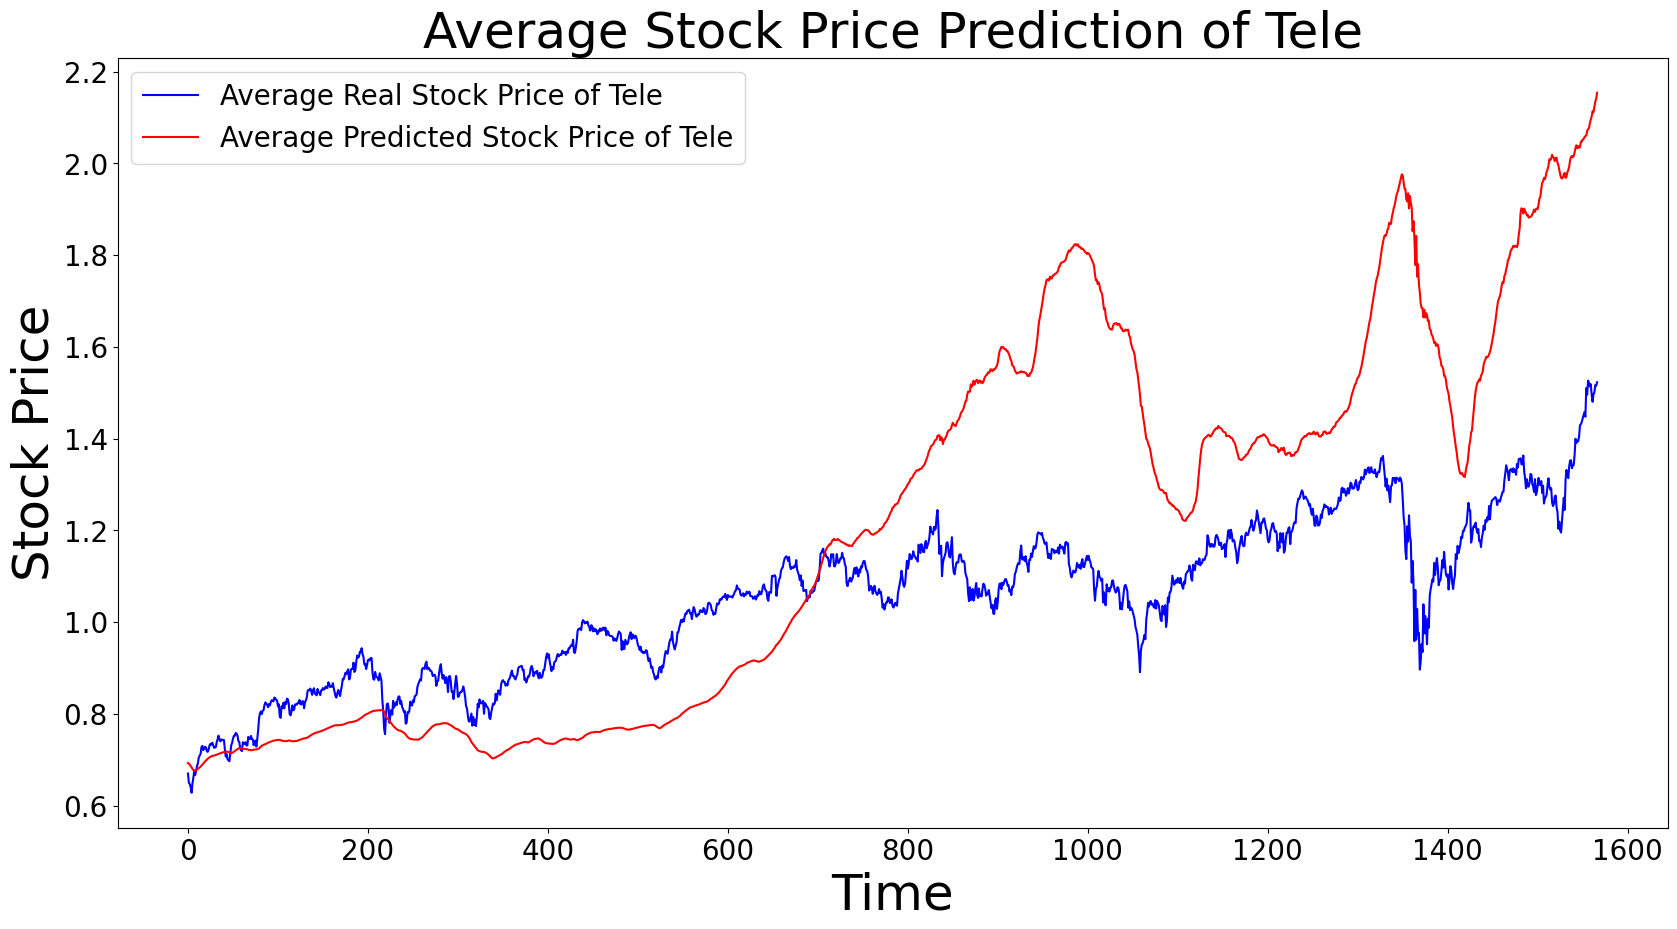

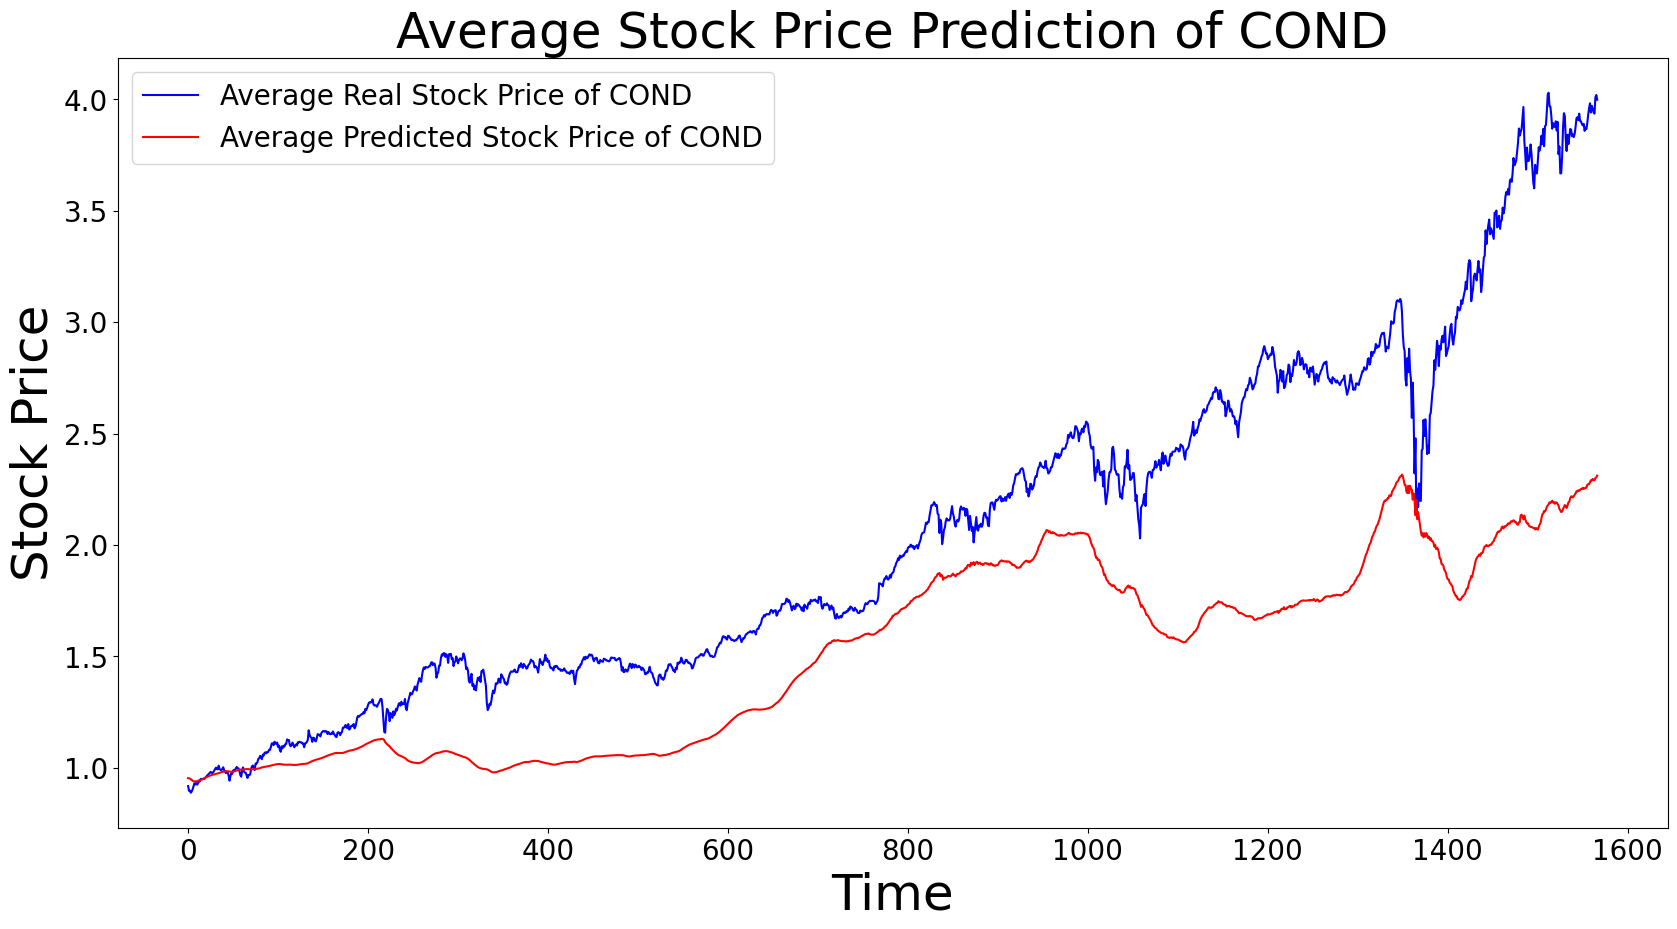

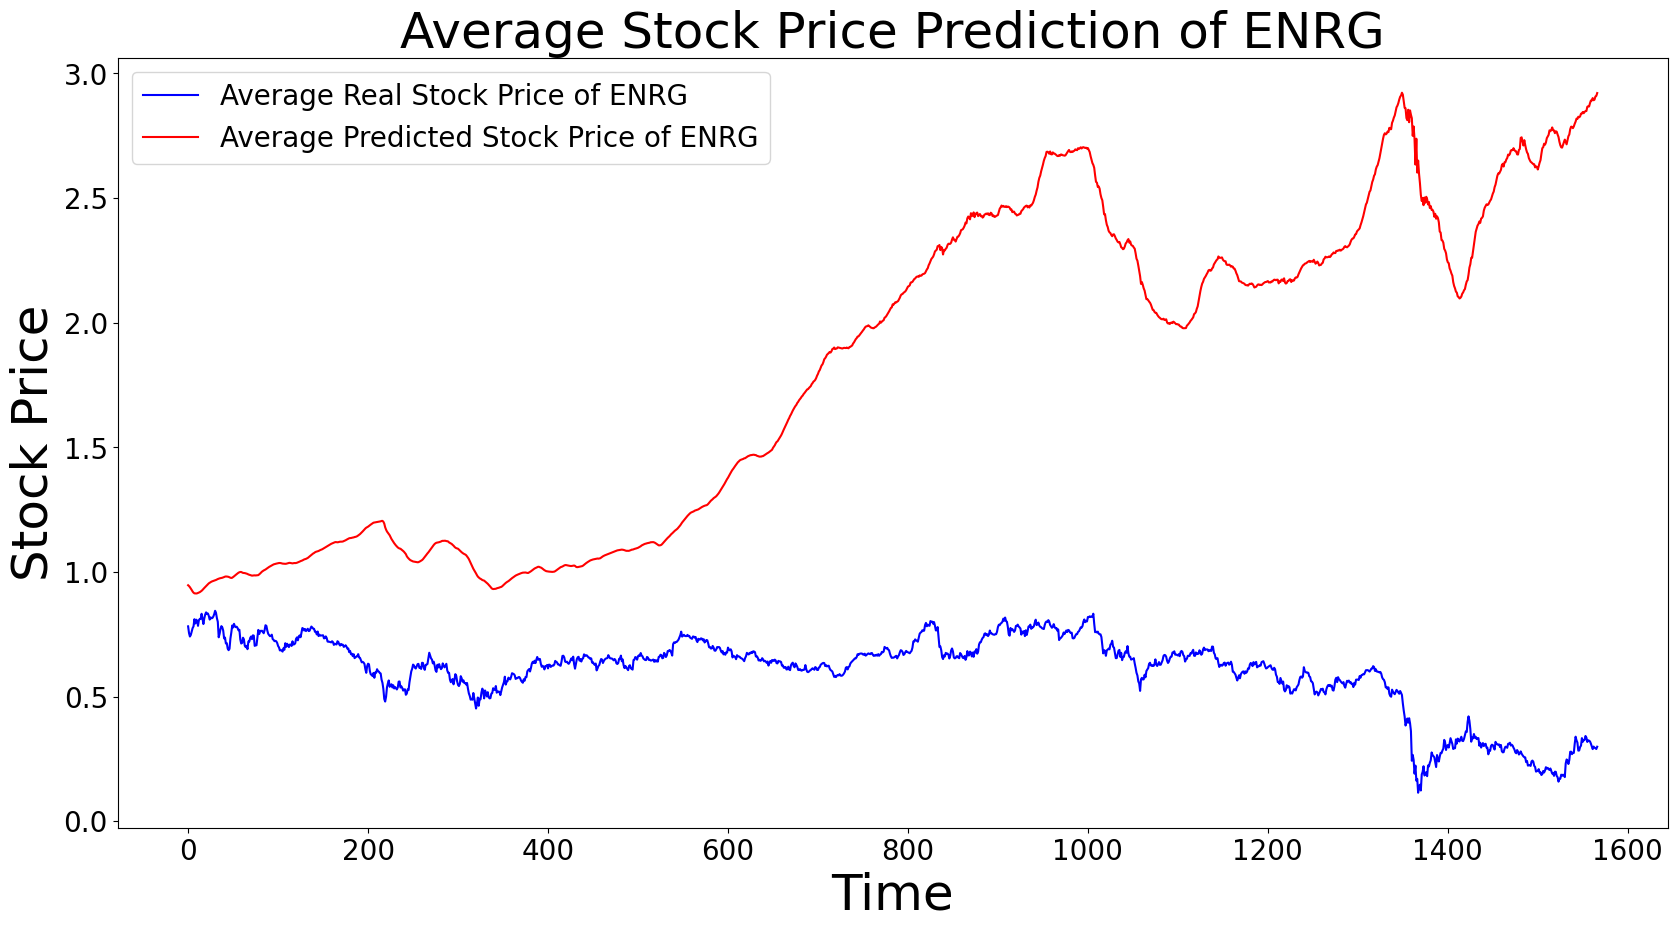

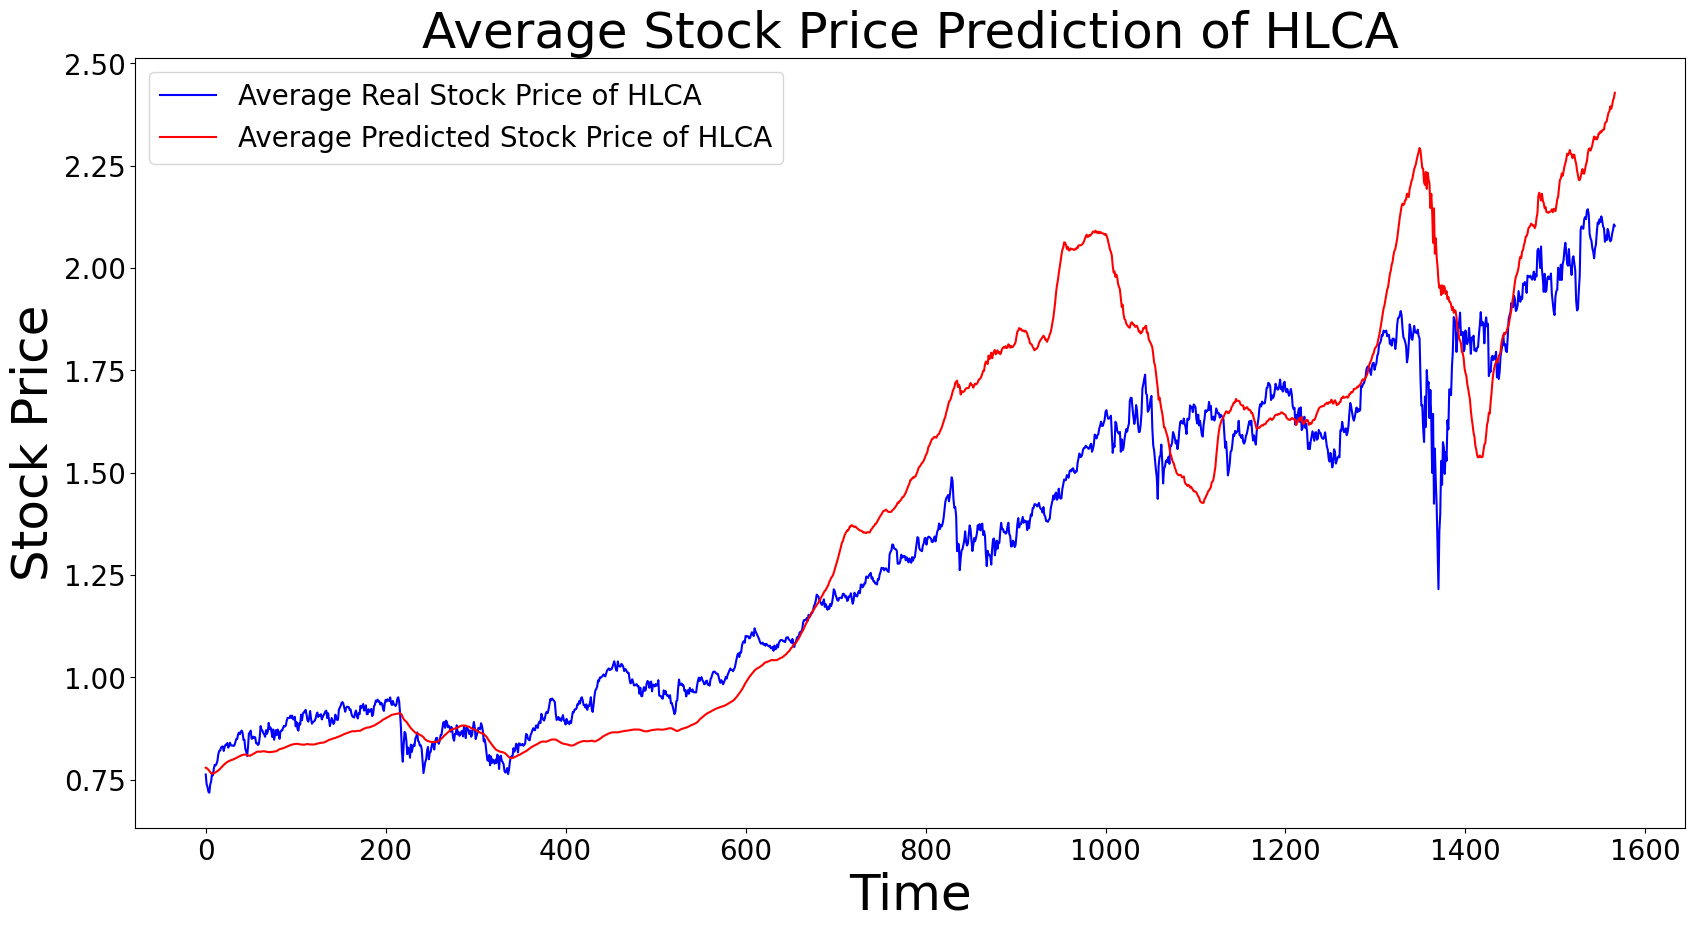

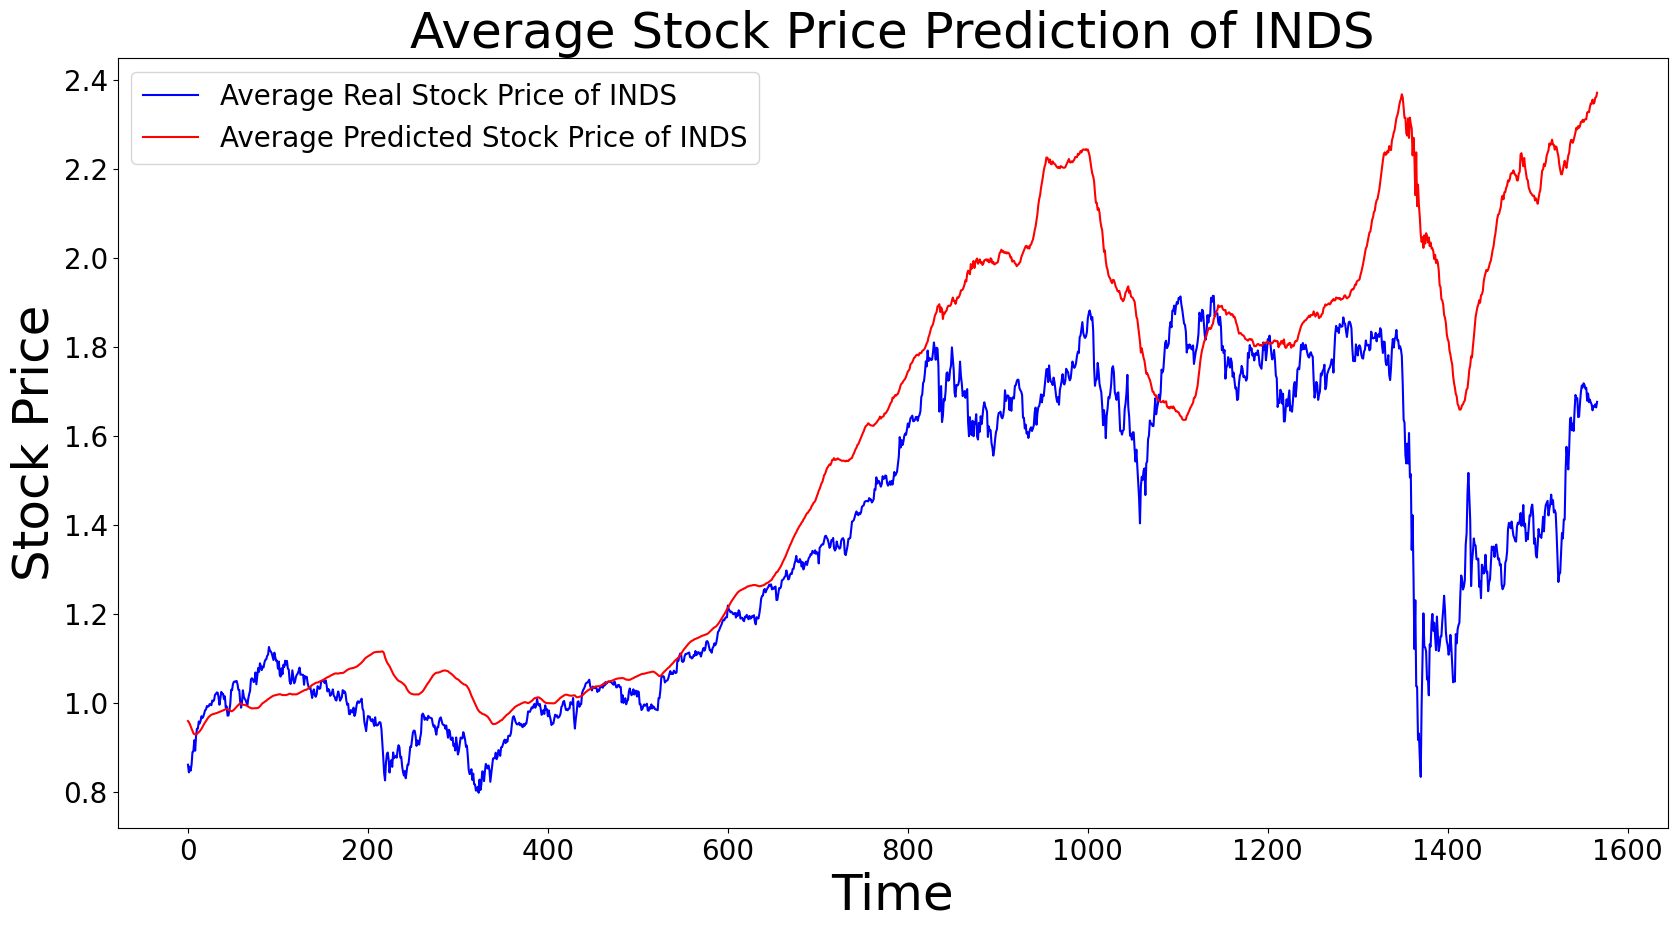

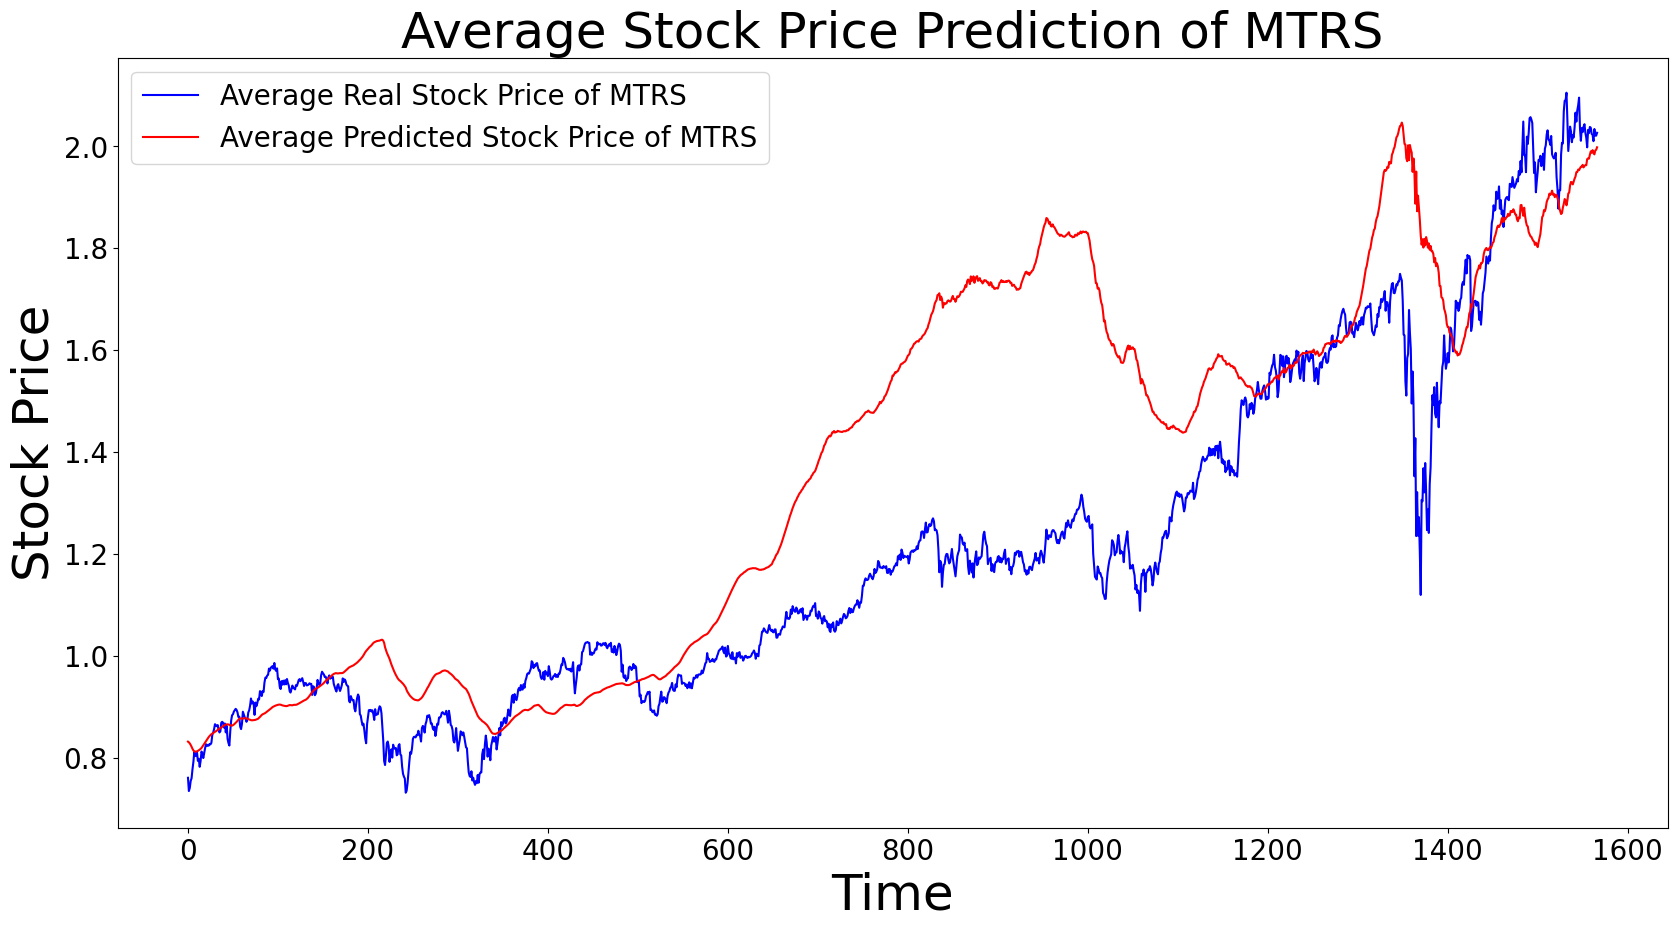

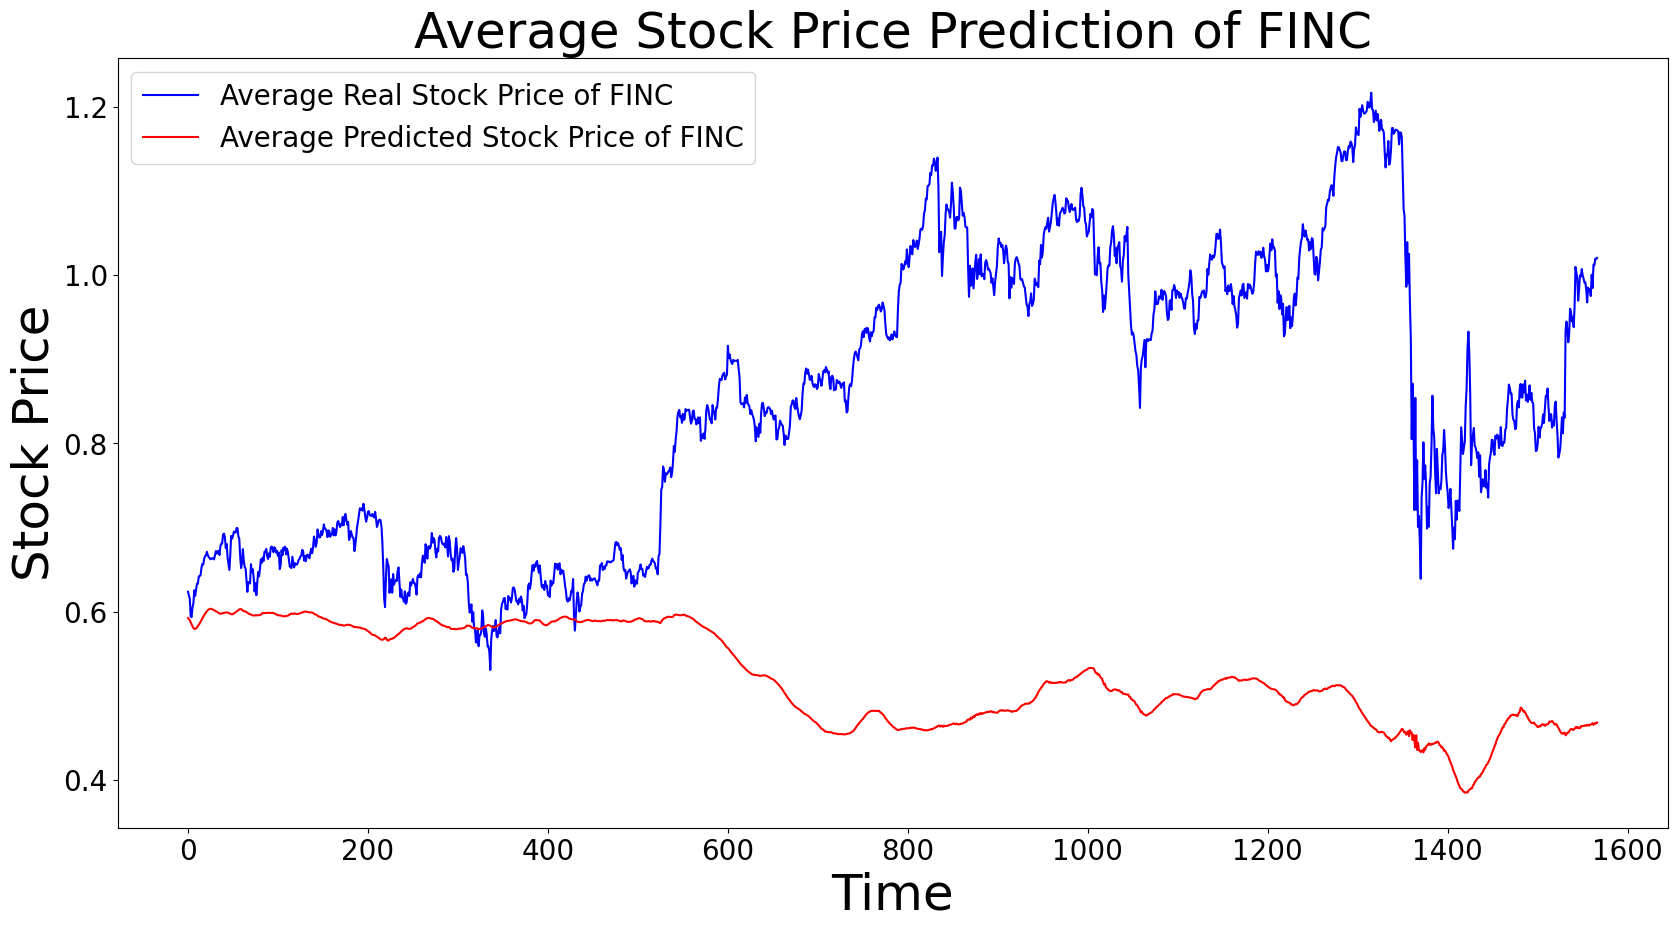

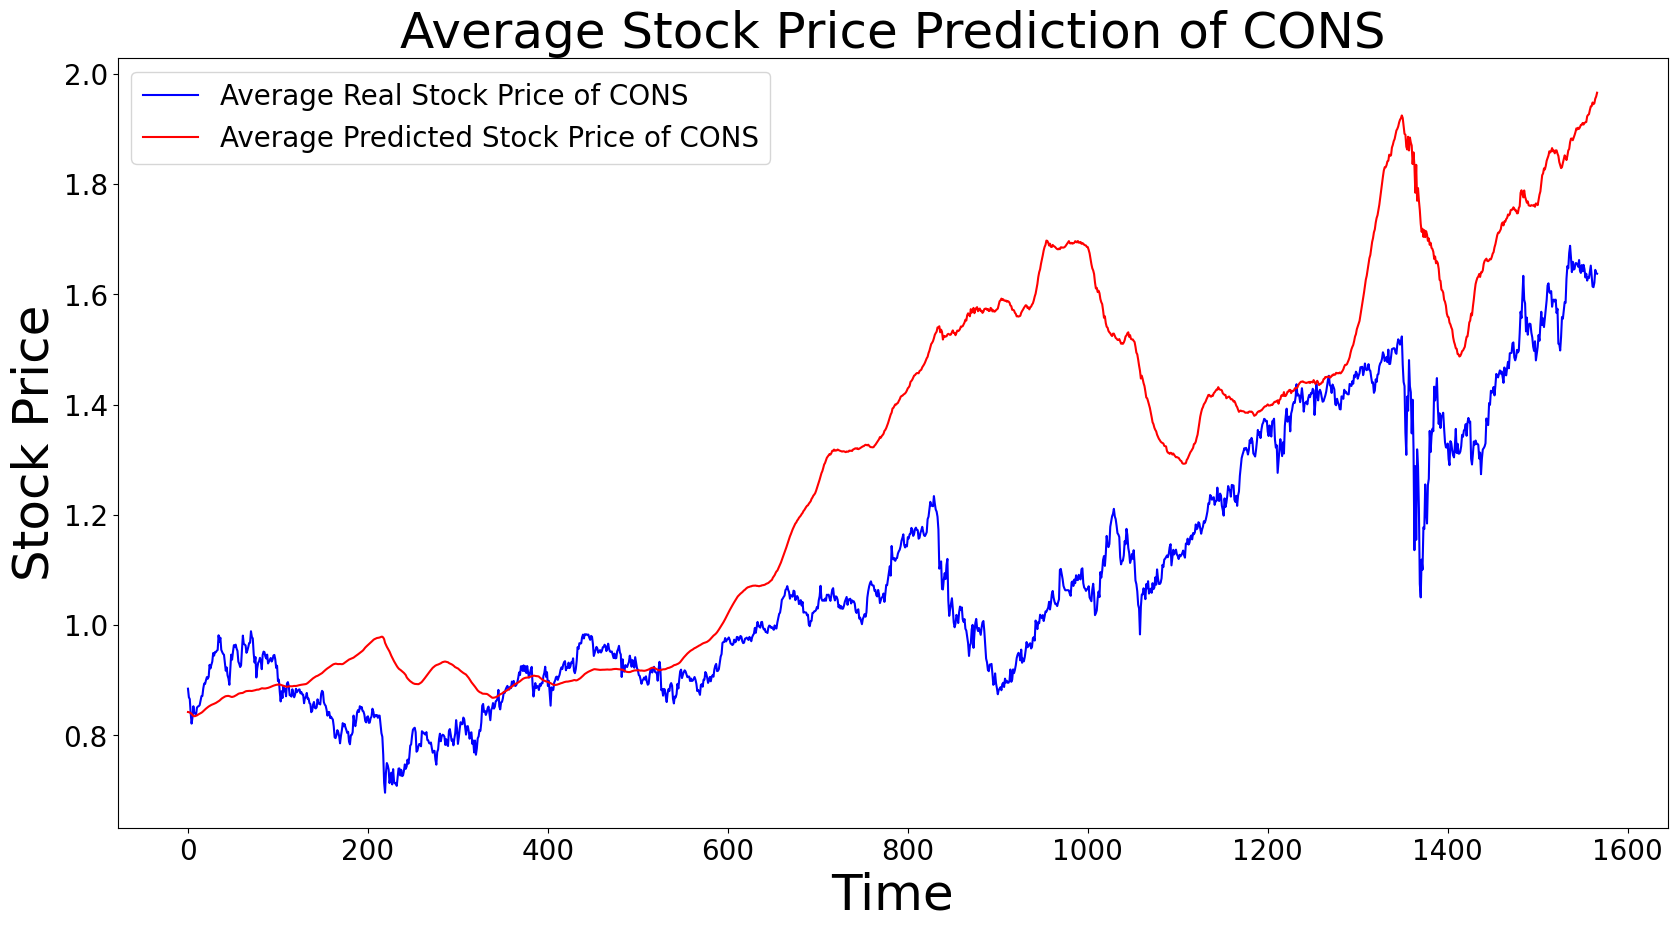

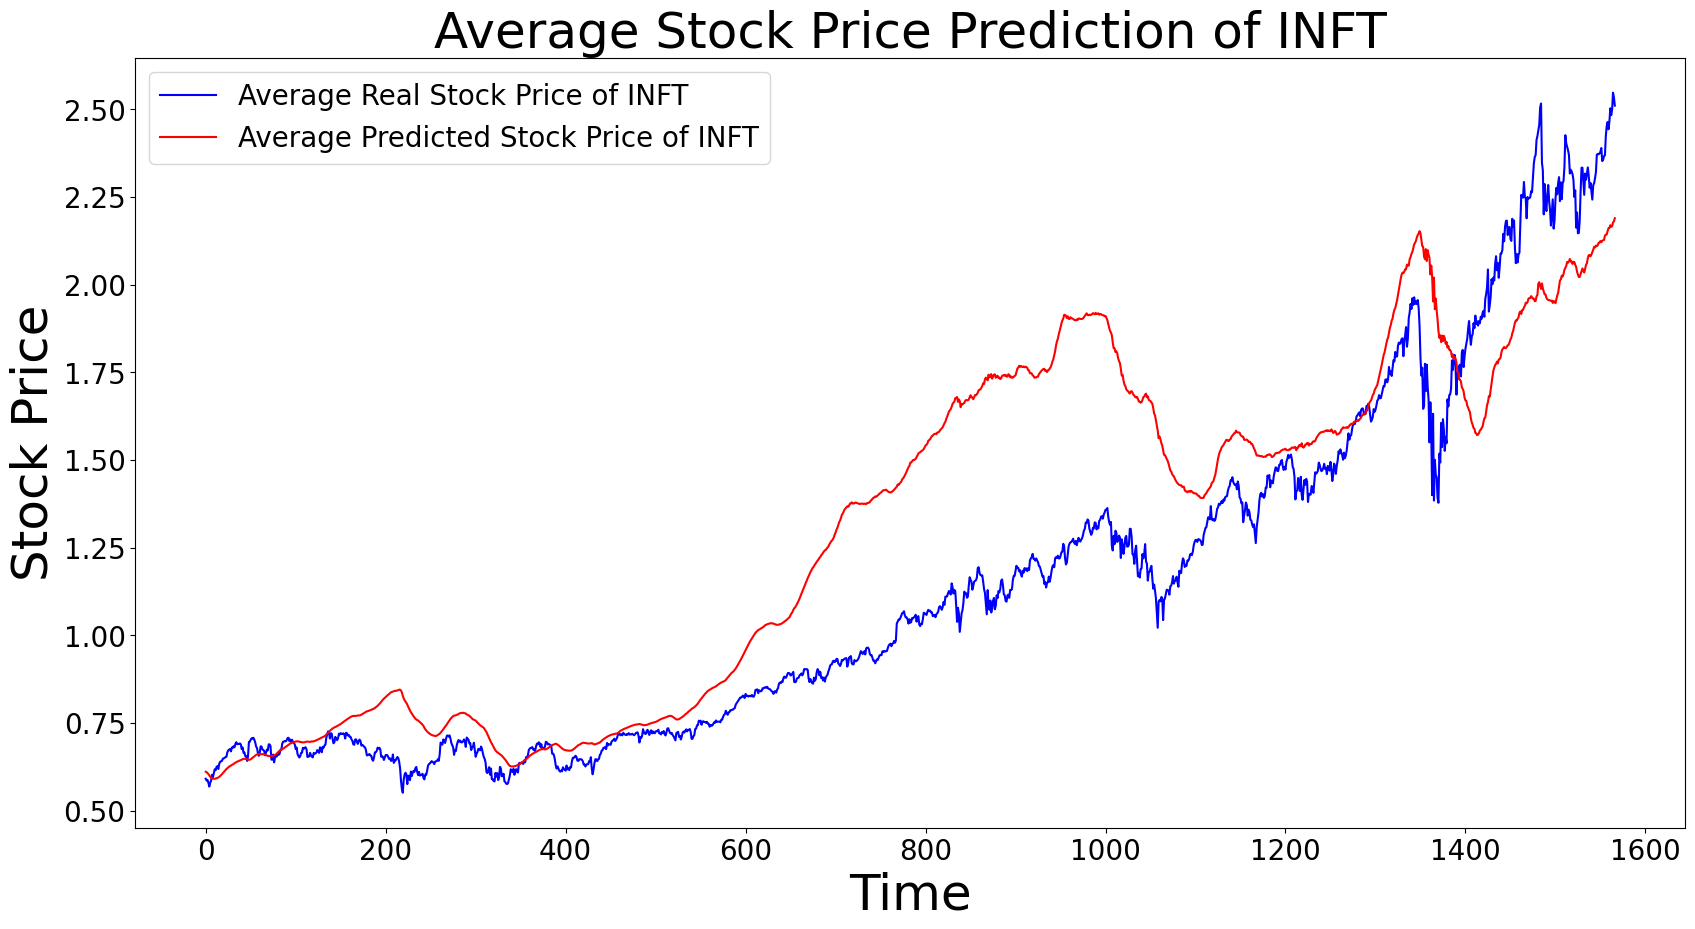

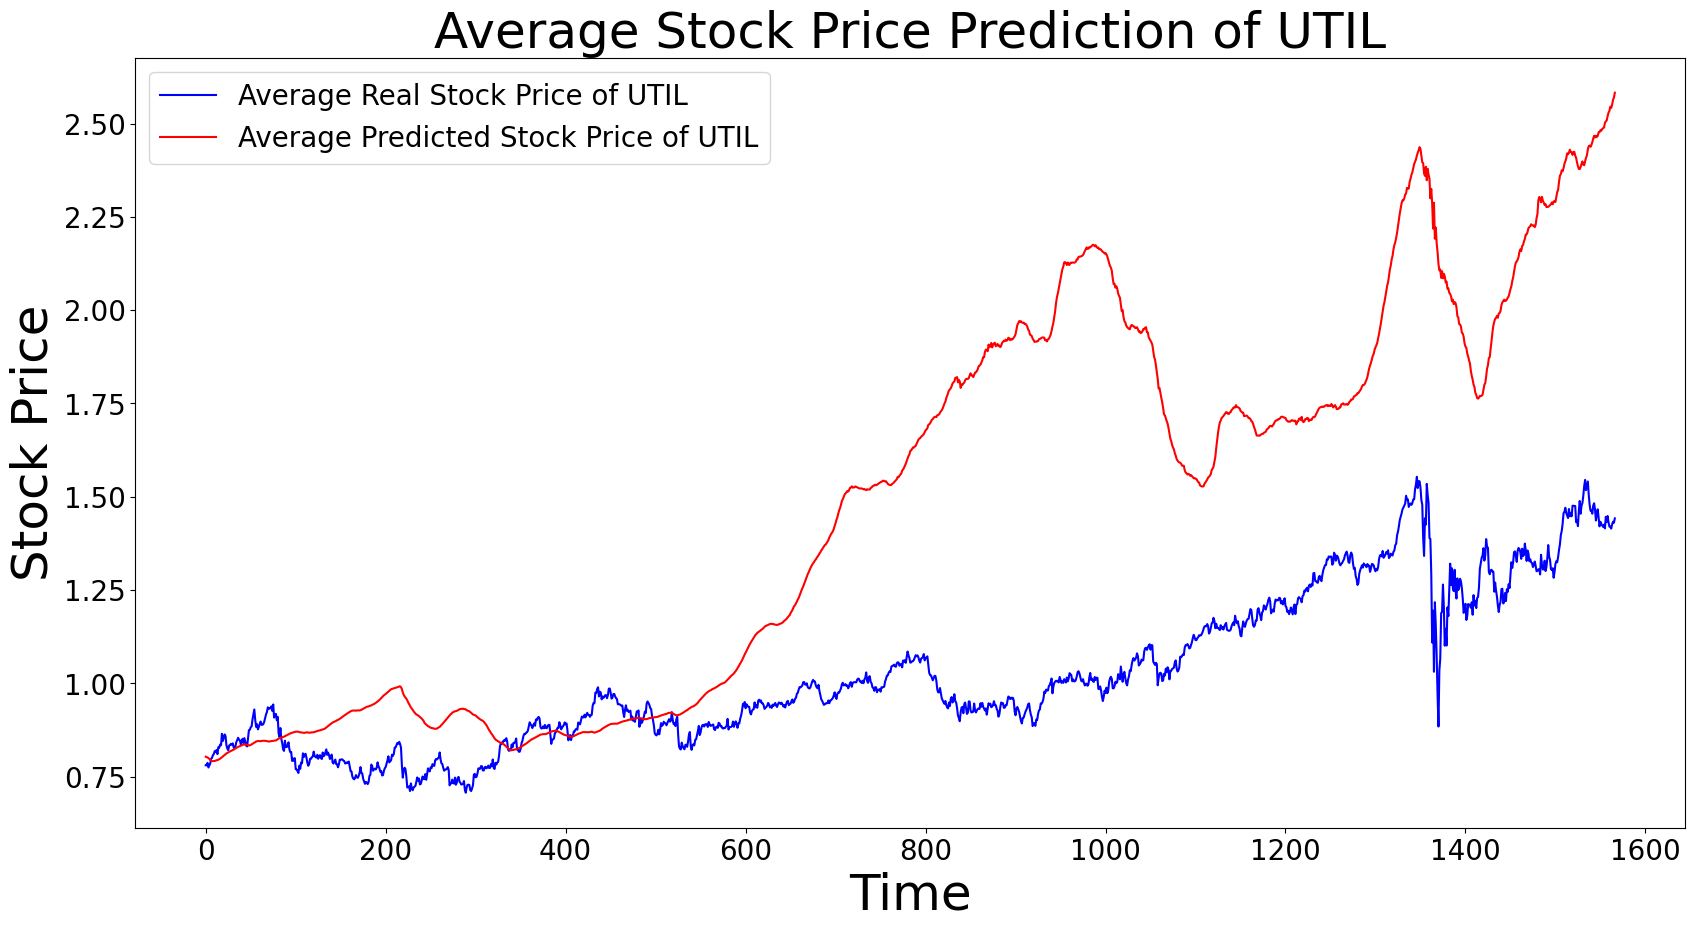

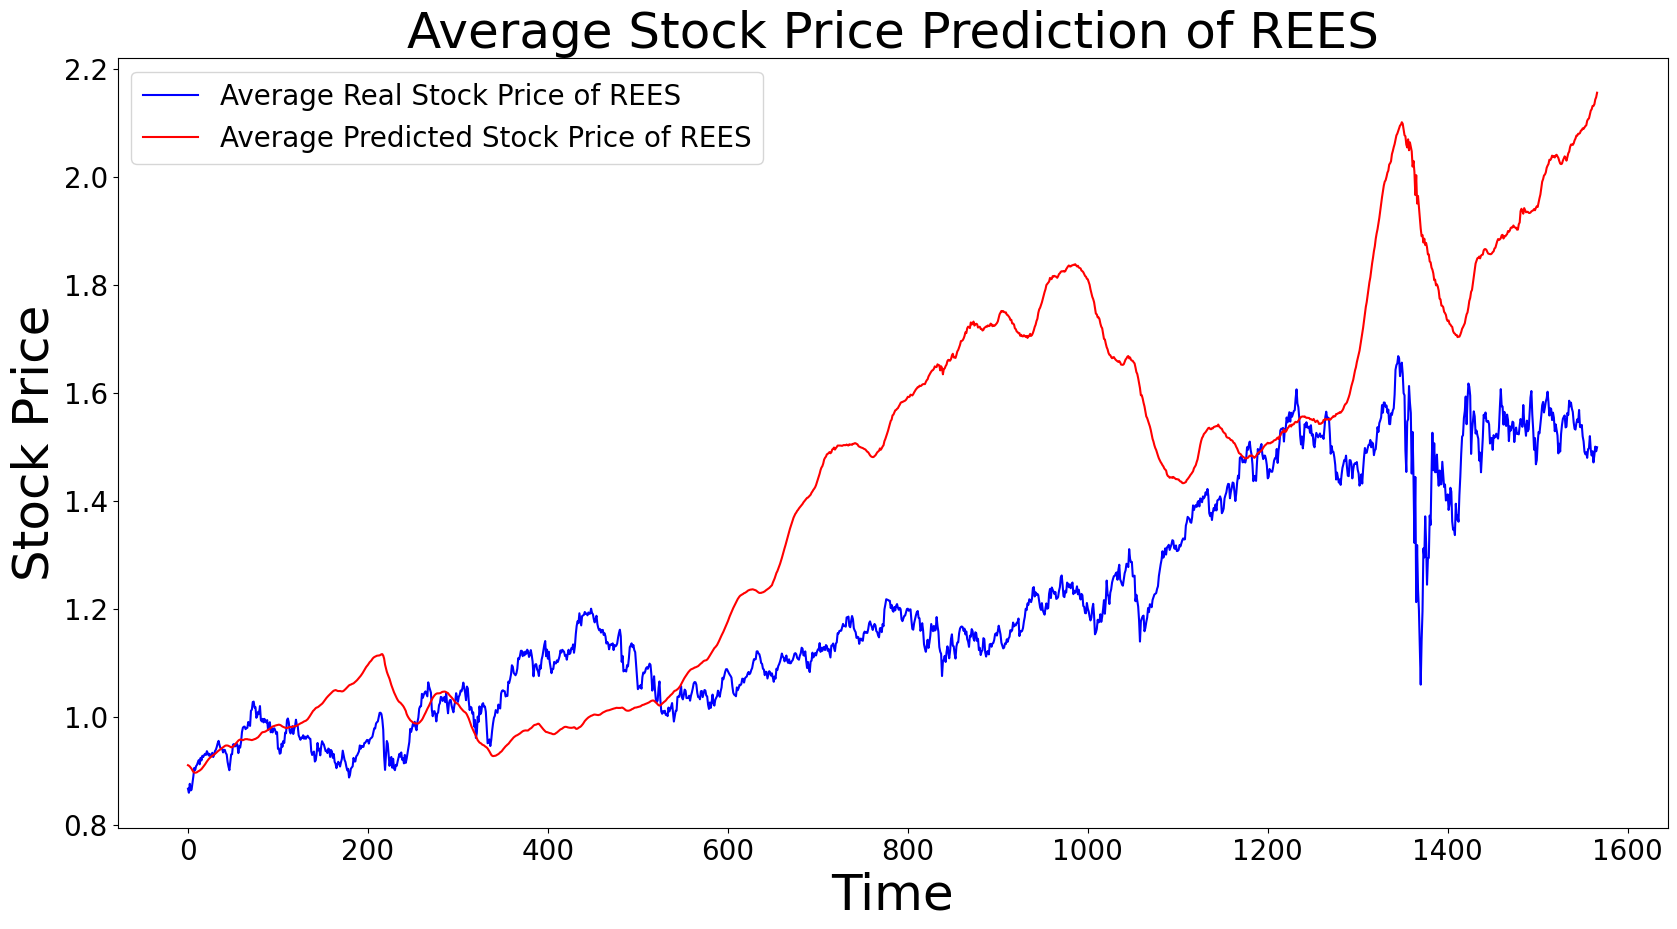

In [18]:
# 각 섹터별 예측값&실제값 그래프 그리기

plt.rcParams['font.size'] = 20

for sector in stocks:
    plt.figure(figsize=(20,10))

    # 실제 데이터 그래프
    avg_test_y = np.mean([test_y[:, company_list.index(company)] for company in stocks[sector]], axis=0)
    plt.plot(avg_test_y, color='blue', label='Average Real Stock Price of ' + sector)

    # 예측 데이터 그래프
    avg_pred_y = np.mean([pred_y[:, company_list.index(company)] for company in stocks[sector]], axis=0)
    plt.plot(avg_pred_y, color='red', label='Average Predicted Stock Price of ' + sector)

    plt.title('Average Stock Price Prediction of ' + sector, fontsize=36)
    plt.xlabel('Time', fontsize=36)
    plt.ylabel('Stock Price', fontsize=36)
    plt.legend()
    plt.show()


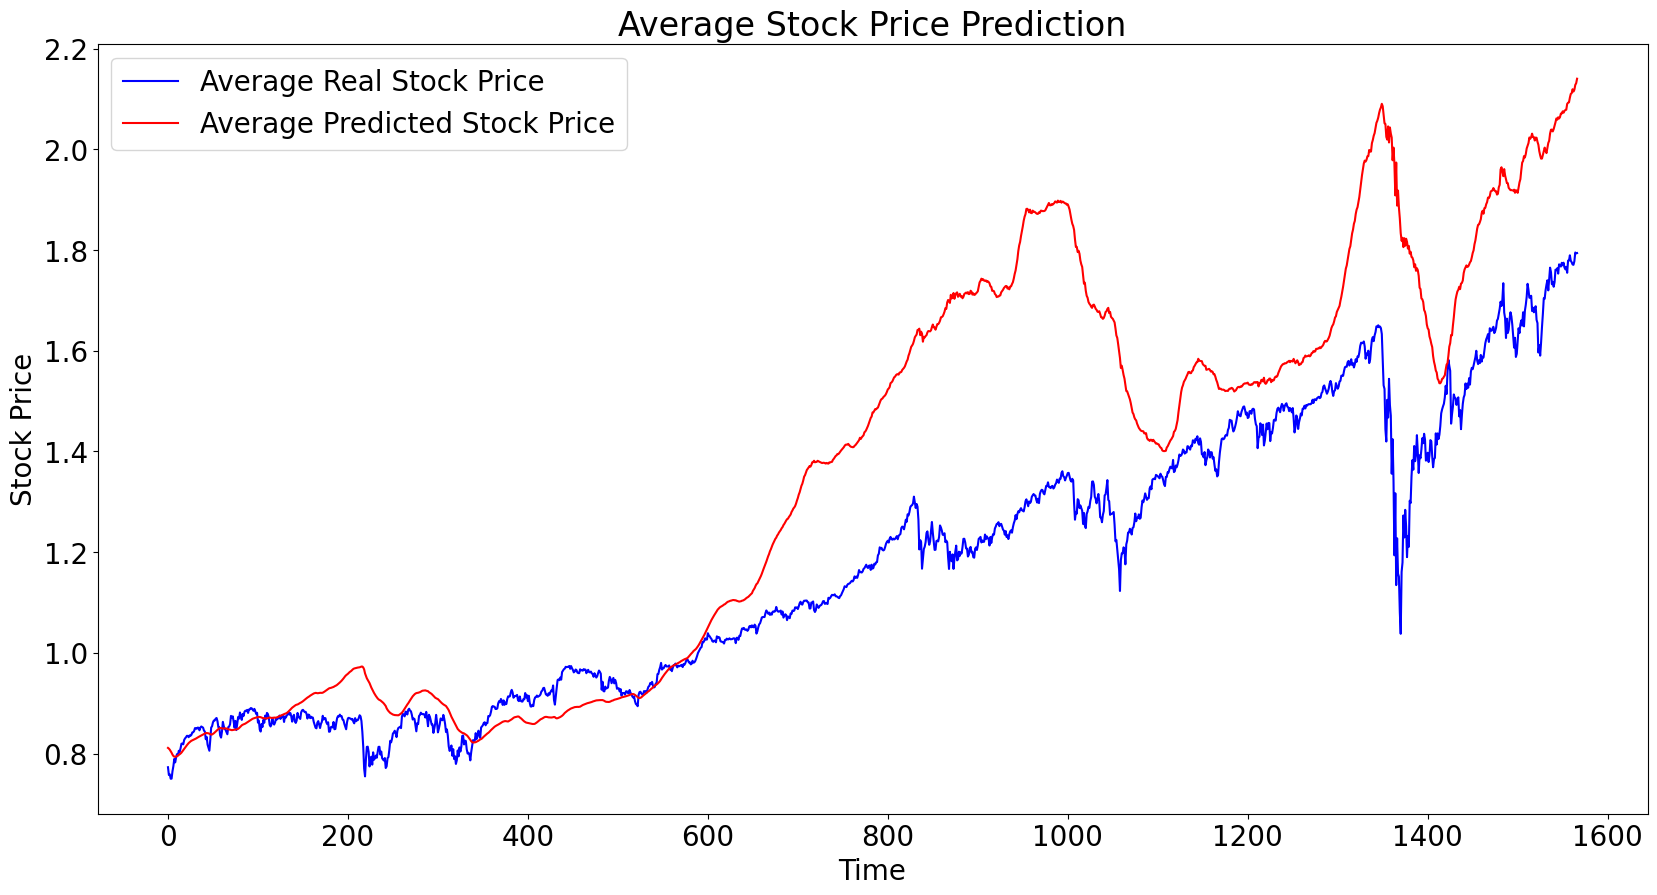

In [17]:
# 모든 주식의 평균 예측값& 실제값 그래프 그리기

plt.rcParams['font.size'] = 20

plt.figure(figsize=(20,10))

# 실제 데이터 그래프
avg_test_y = np.mean(test_y, axis=1)
plt.plot(avg_test_y, color='blue', label='Average Real Stock Price')

# 예측 데이터 그래프
avg_pred_y = np.mean(pred_y, axis=1)
plt.plot(avg_pred_y, color='red', label='Average Predicted Stock Price')

plt.title('Average Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
